In [28]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import holidays

In [ ]:
def add_featuresSDU(df):
  ####################### TIMED BASED FEATURES  #######################
  df['Day_of_Week'] = df.index.dayofweek
  df['Hour_of_Day'] = df.index.hour
  df['Month_of_Year'] = df.index.month
  df['Year'] = df.index.year
  df['Day/Night'] = (df['Hour_of_Day'] >= 6) & (df['Hour_of_Day'] <= 18)

  # Add holiday
  dk_hols = holidays.DK(years=range(df.index.year.min(), df.index.year.max() + 1))
  df['IsHoliday'] = df.index.to_series().dt.date.isin(dk_hols).astype(int)

  # Add weekend
  df['Weekend'] = (df['Day_of_Week'] >= 5).astype(int)

  ####################### CYCLIC FEATURES  #######################

  df['HourSin'] = np.sin(2 * np.pi * df['Hour_of_Day'] / 24)
  df['HourCos'] = np.cos(2 * np.pi * df['Hour_of_Day'] / 24)
  df['DayOfWeekSin'] = np.sin(2 * np.pi * df['Day_of_Week'] / 7)
  df['DayOfWeekCos'] = np.cos(2 * np.pi * df['Day_of_Week'] / 7)
  df['MonthOfYearSin'] = np.sin(2 * np.pi * df['Month_of_Year'] / 12)
  df['MonthOfYearCos'] = np.cos(2 * np.pi * df['Month_of_Year'] / 12)

  ####################### SEASONAL FEATURES  #######################
  month_to_season = {1: 0, 2: 0, 3: 1, 4: 1, 5: 1, 6: 2,
                     7: 2, 8: 2, 9: 3, 10: 3, 11: 3, 12: 0}
  df['Season'] = df['Month_of_Year'].map(month_to_season)

  ####################### HISTORICAL CONSUMPTION FEATURES  #######################
  df['Aggregated_charging_load_1h'] = df['Aggregated charging load'].shift(1)
  df['Aggregated_charging_load_6h'] = df['Aggregated charging load'].shift(6)
  df['Aggregated_charging_load_12h'] = df['Aggregated charging load'].shift(12)
  df['Aggregated_charging_load_24h'] = df['Aggregated charging load'].shift(24)
  df['Aggregated_charging_load_1w'] = df['Aggregated charging load'].shift(24*7)
  df['Aggregated_charging_rolling'] = df['Aggregated charging load'].rolling(window=24).mean()

  return df


def convert_SDU_to_hourly(df):
  df = df.set_index('Timestamp')

  hourly = df.resample('h').agg({
      'Total number of EVs':      'sum',
      'Number of charging EVs':   'sum',
      'Number of driving EVs':    'sum',
      'Total grid load':          'sum',
      'Aggregated base load':     'sum',
      'Aggregated charging load': 'sum',
      'Overload duration [min]':  'sum',
  })

  return hourly

def parse_date(date):
    return pd.to_datetime(date, format='%b %d, %Y, %I:%M:%S %p')


def filter_data(start_date, end_date, data):
    return data[(data.index >= start_date) & (data.index <= end_date)].copy()


   
# Define the start and end dates
start_date = pd.to_datetime('2024-12-31')
end_date = pd.to_datetime('2032-12-31')

# Load the data
df = pd.read_csv('./DumbCharging_2020_to_2032/Measurements.csv', parse_dates=['Timestamp'])
df = convert_SDU_to_hourly(df)
feature_df = add_featuresSDU(df)
final_df = filter_data(start_date, end_date, feature_df)
final_df.to_csv('Measurements_with_features.csv', index=True)
print(final_df.head(24))

/var/folders/9x/yl6kp0_j23s302pc3z00dpjh0000gn/T/ipykernel_14784/4120714716.py:70: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv('./DumbCharging_2020_to_2032/Measurements.csv', parse_dates=['Timestamp'])


                     Total number of EVs  Number of charging EVs  \
Timestamp                                                          
2024-12-31 00:00:00                  3.0                     0.0   
2024-12-31 01:00:00                  3.0                     0.0   
2024-12-31 02:00:00                  3.0                     0.0   
2024-12-31 03:00:00                  3.0                     0.0   
2024-12-31 04:00:00                  3.0                     0.0   
2024-12-31 05:00:00                  3.0                     0.0   
2024-12-31 06:00:00                  3.0                     0.0   
2024-12-31 07:00:00                  3.0                     0.0   
2024-12-31 08:00:00                  3.0                     0.0   
2024-12-31 09:00:00                  3.0                     0.0   
2024-12-31 10:00:00                  3.0                     0.0   
2024-12-31 11:00:00                  3.0                     0.0   
2024-12-31 12:00:00                  3.0        

In [23]:
# How many columns are there?
print(f"Number of columns: {len(final_df.columns)}")

Number of columns: 27


Overload duration slots:
                     Overload duration [min]  Aggregated charging load
Timestamp                                                             
2031-10-21 16:00:00                      1.0                    324.92
2031-10-21 17:00:00                      7.0                    329.42
2031-10-22 17:00:00                     17.0                    334.24
2031-11-12 17:00:00                      3.0                    319.48
2031-12-05 17:00:00                      3.0                    319.56
2031-12-09 17:00:00                      1.0                    312.54
2031-12-19 17:00:00                      4.0                    323.12
2032-01-02 17:00:00                     32.0                    348.02
2032-01-04 17:00:00                      1.0                    306.10
2032-01-04 18:00:00                      1.0                    291.30
2032-01-06 16:00:00                      1.0                    334.40
2032-01-06 17:00:00                      4.0        

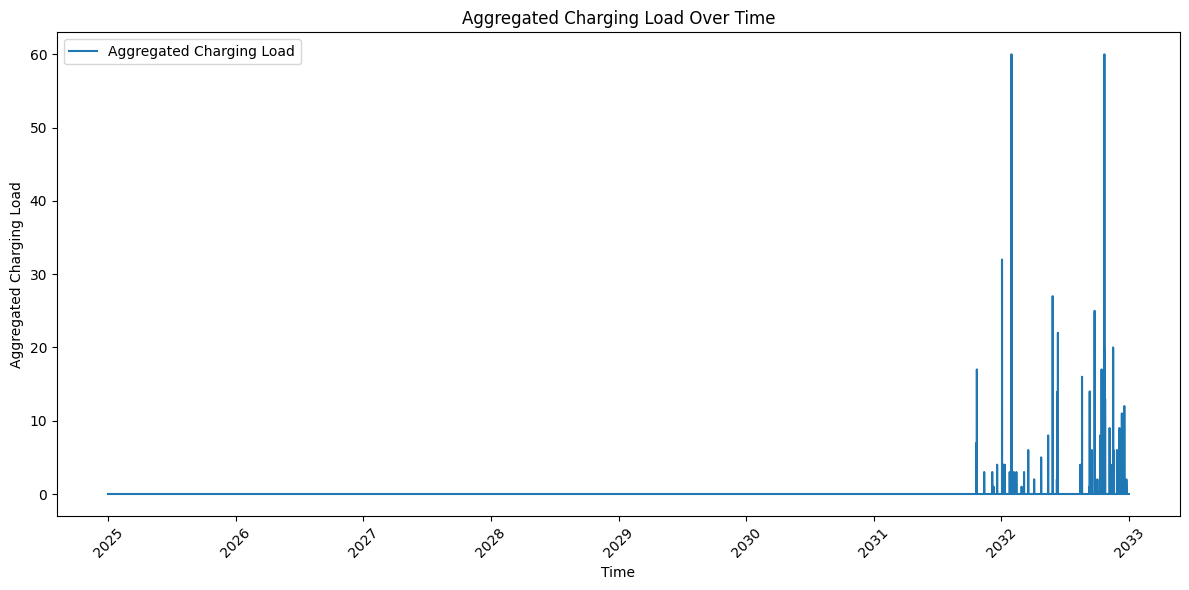

In [22]:
# Print all the slots with overload duration
overload_duration = final_df[final_df['Overload duration [min]'] > 0]
print("Overload duration slots:")
print(overload_duration[['Overload duration [min]', 'Aggregated charging load']].head(24))
# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(final_df.index, final_df['Overload duration [min]'], label='Aggregated Charging Load')
plt.title('Aggregated Charging Load Over Time')
plt.xlabel('Time')
plt.ylabel('Aggregated Charging Load')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()
